# Objectives

- Identify disease biomarkers.

- Build an inductive model.

# Dataset Selection

- Datasets: 191

- Samples: 29.198

### OpenRefine:
A powerful free, open source tool for working with messy data: cleaning it, transforming it from one format into another and extending it with web services and external data.

- Retrieve platform *technology* from [Gene Expression Omnibus](https://0-www-ncbi-nlm-nih-gov.brum.beds.ac.uk/geo/browse/?view=platforms):

  - high-throughput sequencing (64 datasets: 1473 samples)

  - spotted oligonucleotide (35 datasets: 24.119 samples)

  - in situ oligonucleotide (61 datasets: 2987 samples)

  - RT-PCR (28 datasets: 544 samples)

  - other (3 datasets: 75 samples)

- Delete datasets:

  - *technology* = other | [RT-PCR](https://biosistemika.com/blog/qpcr-microarrays-rna-sequencing-choose-one)

  - *dataset* = EMIR00000180 (64 samples) ([samples in common with EMIR00000177 but inconsistent values](./report.numbers))

  - *dataset* = EMIR00000091 | EMIR00000092 | EMIR00000097 | EMIR00000101 (subsets of EMIR00000102)

# Metadata Preprocessing

- Features: 267

### OpenRefine

- Add dataset-level features.

- Split and transpose key:value features.

- Delete samples:

   - *organism* ≠ Homo sapiens (22 samples)

   - *channel_count* ≠ 1 (189 samples)

   - *molecule* ≠ total RNA (2 samples)

   - Disease status not clear (EMIR00000090: 13, EMIR00000008: 4, EMIR00000067: 3, EMIR00000102: 30, EMIR00000168: 9)

In [14]:
import pandas as pd


def keep_first_occurrence(row):
    """
    Delete repeated occurrences of the same value in a row
    """
    new_row = []
    for value in row:
        new_row.append(value if value not in new_row else None)
    return pd.Series(new_row, index=row.index)


metadata = pd.read_csv('data/PD.csv', dtype=str).apply(keep_first_occurrence, axis=1)

# Remove columns containing a unique value for all the rows
metadata.drop(metadata.columns[metadata.apply(pd.Series.nunique) == 1], axis=1, inplace=True)

# Remove empty columns
metadata.dropna(axis=1, how='all', inplace=True)

metadata.to_csv('data/PD.csv', index=False)

### OpenRefine

- Merge equivalent features associated to different datasets.

- Rename features consistently.

- Delete irrelevant or redundant features (e.g. *state* has an almost 1:1 relationship with *city*).

- Delete features where missing values ⪆ 98%.

- Refine dataset-level features (based on majority class) using sample-level data: *sample_type*, *disease*, *disease_type*, *body_site*.
        
- Detect *healthy_control* samples in each dataset exploiting sample description.

- Extract *metastasis* and *stage* from sample description.

- Standardize *age*, *sex*, *city*, *disease*, *disease_type* values.

# miRNA Preprocessing 

In [1]:
import pandas as pd


name_conversions = {}
for _, row in pd.read_csv('data/raw/converter.csv', index_col=0).iterrows():
    for i in range(len(row) - 1):
        if row[i] != row[-1]:
            name_conversions[row[i]] = row[-1]
            

def transform_miRNA_name(name):
    """
    Delete whitespaces, standardize separators and remove version suffix from miRNA names. Update miRNA names to the latest version of miRBase.
    """
    name = name.replace(' ', '')
    name = name.replace(',hsa', '|hsa')
    name = name.replace('+hsa', '|hsa')
    name = name.replace('/hsa', '|hsa')
    name = name.replace('_hsa', '|hsa')
    name = name.split('_v1')[0]
    name = name.split('_v2')[0]
    name = name_conversions.get(name, name)
    return name


samples_per_dataset = pd.read_csv('data/PD.csv').groupby('dataset')['sample_id'].agg(list).to_dict()
df_list = []

for dataset in samples_per_dataset.keys():

    df = pd.read_csv(f'data/raw/exp/{dataset}_exp.csv', converters={0: transform_miRNA_name})

    # Delete rows indexed by the same miRNA name (dataset anomaly)
    df = df.drop_duplicates(df.columns[0])

    # Delete rows indexed by miRNA names containing 'plus', 'novel' (unknown miRNA), 'hsa-miR-647+a703' (dataset anomaly), '_var2' (dataset contains identical suffix-free miRNA)
    df = df[df[df.columns[0]].str.contains('plus|novel|hsa-miR-647\+a703|_var2') == False]

    # Transpose data
    df = df.set_index(df.columns[0]).T

    # Remove samples not included in metadata
    df = df.loc[samples_per_dataset[dataset]]
    
    df_list.append(df)

# Concatenate data into a single dataframe
values = pd.concat(df_list)

pd.DataFrame(values.count(axis=0), columns=['samples']).to_csv('data/miRNA.csv')
values.to_csv('data/EXP.csv')

- [Converter](http://mirandola.iit.cnr.it/converter.php)

- [Plus](https://www.tecan.com/hubfs/Tecan_Journal/200702/TecanJournal2007-02_page_16.pdf)

- [Novel](https://academic.oup.com/bfg/article/15/1/65/1742523)

# Visualization

Total samples: 28090


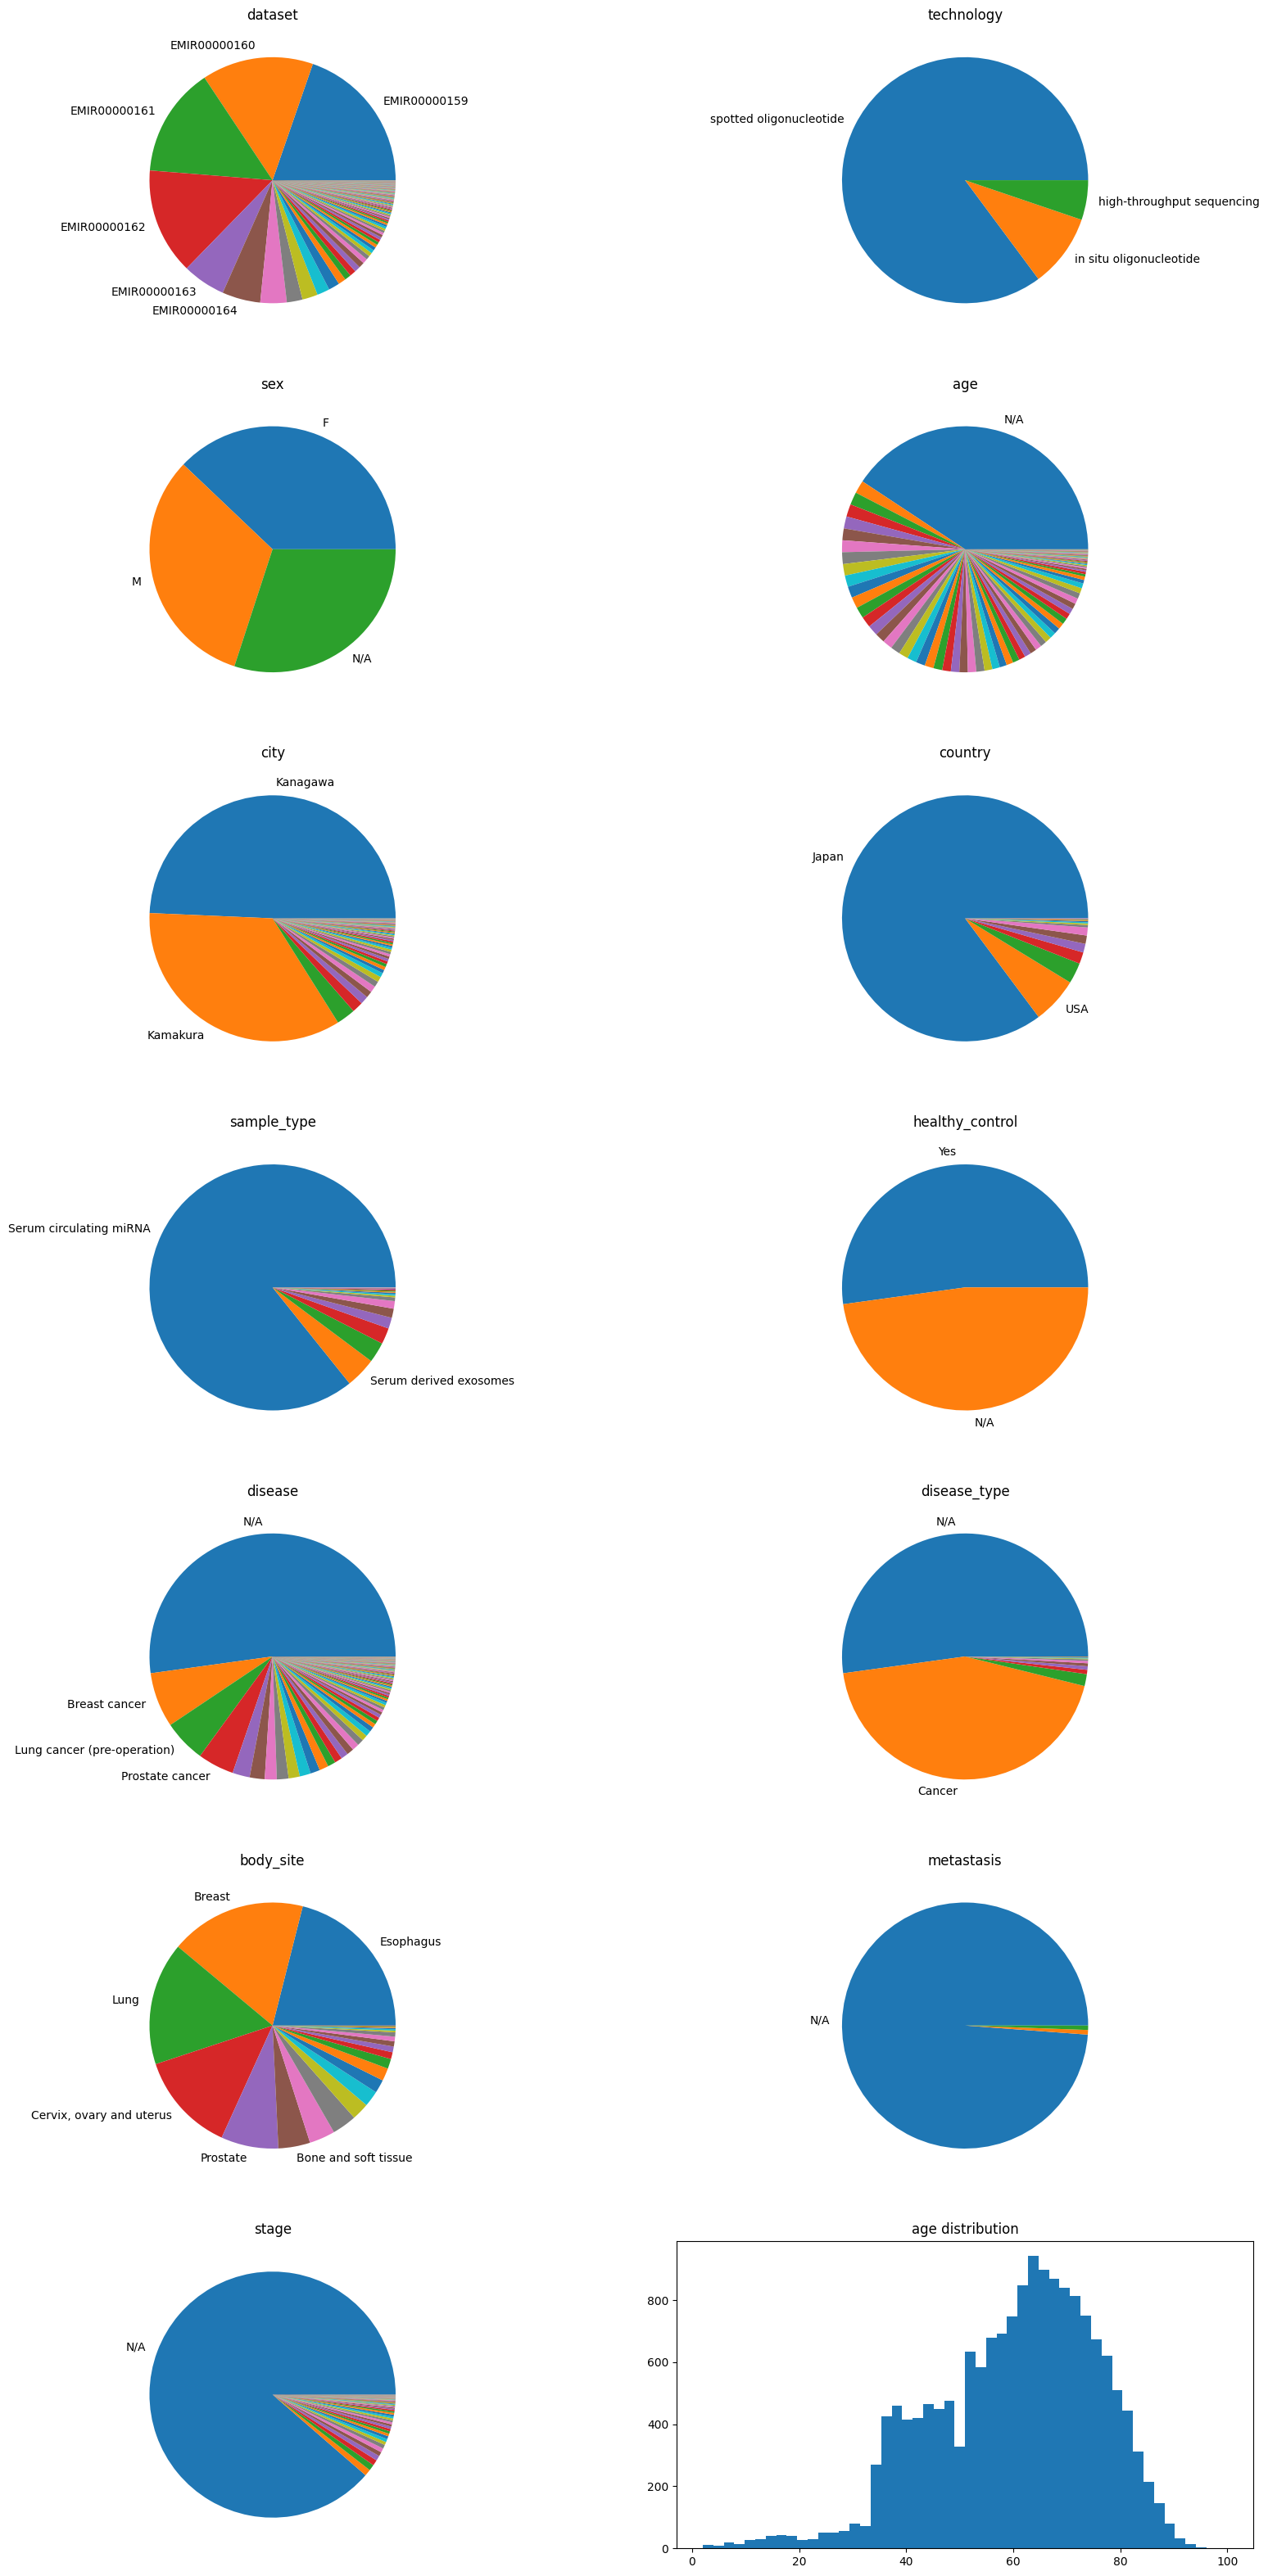

In [4]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('data/PD.csv', index_col='sample_id')
print(f'\033[1mTotal samples: {len(df)}')

fig, axs = plt.subplots(7, 2, figsize=(20, 40))
for i, column in enumerate(df.columns):

    counts = df[column].value_counts(dropna=False)
    labels = [label if count > 1000 else '' for count, label in zip(counts, counts.index)]
    labels = ['N/A' if pd.isnull(label) else label for label in labels]
    axs[i//2, i%2].set_title(f'{column}')
    axs[i//2, i%2].pie(counts, labels=labels)

axs[-1, -1].set_title('age distribution')
axs[-1, -1].hist(df['age'], bins=50)

plt.show()

# Issues


- Previous experiment: *disease* attribute extracted from dataset table but each dataset contains multiple diseases and healthy samples.

- Dataset integration is not recommended. If values in multiple datasets are not comparable, generated results are biased:

  - Different datasets use different value range: [0,1], [-∞,0], [0,+∞], [-∞,+∞]. Model will map the dataset range to its disease.<br><br>

- Select datasets and diseases:

  - Frequency threshold

  - Irrelevance (e.g.: *Sedentary and trained older adults*, *Healthy individuals*)

  - Absence of healthy samples (some datasets consider specific aspects of a particular disease)

- Select miRNA:

  - Frequency threshold
    
  - Presence of separators: ...|...|...

- Interpret miRNA values equal to 0.

- Meaning of *metastasis* and *stage* is dataset-specific.

- Aggregate *disease* and *stage* values.

- Define graph structure.

# Deep Graph Library

An easy-to-use, high performance and scalable Python package for deep learning on graphs.

In [ ]:
import os

os.environ["DGLBACKEND"] = "pytorch"
import dgl
import numpy as np
import torch


# A DGL Dataset object may contain one or multiple graphs. A DGL graph can store node features and edge features in two dictionary-like attributes called ndata and edata.

# Construct a graph by specifying the list of source and destination nodes. Nodes in the graph have consecutive IDs starting from 0.
# Edges in the graph have consecutive IDs starting from 0, and are in the same order as the list of source and destination nodes during creation.

# Construct a directed star graph with 5 leaves. The center node’s ID is 0. The edges go from the center node to the leaves.
g = dgl.graph(([0, 0, 0, 0, 0], [1, 2, 3, 4, 5]))

# If you have an undirected graph, it is better to convert it into a bidirectional graph first via adding reverse edges.
# newg = dgl.add_reverse_edges(g)

# Although the types of node and edge attributes can be arbitrary in real world, DGLGraph only accepts attributes stored in tensors (with numerical contents).
# Consequently, an attribute of all the nodes or edges must have the same shape.
# For categorical attributes (e.g. gender, occupation), consider converting them to integers or one-hot encoding.
# You can assign and retrieve node and edge features via ndata and edata interface.

# Assign a 3-dimensional node feature vector for each node.
g.ndata["x"] = torch.randn(6, 3)
# Assign a 4-dimensional edge feature vector for each edge.
g.edata["a"] = torch.randn(5, 4)
# Assign a 5x4 node feature matrix for each node.  Node and edge features in DGL can be multi-dimensional.
g.ndata["y"] = torch.randn(6, 5, 4)

# DGLGraph object provides various methods to query a graph structure.
print(g.num_nodes())
print(g.num_edges())
# Out degrees of the center node
print(g.out_degrees(0))
# In degrees of the center node - note that the graph is directed so the in degree should be 0.
print(g.in_degrees(0))

# Save graph
dgl.save_graphs("graph.dgl", g)

# Load graph
(g,), _ = dgl.load_graphs("graph.dgl")

# DGL follows the message passing paradigm. Message passing is directional: the message sent from one node 𝑢 to other node 𝑣
# is not necessarily the same as the other message sent from node 𝑣 to node 𝑢 in the opposite direction.